In [1]:
import pandas as pd
import numpy as np

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys

In [3]:
ravdess_path = 'D:/speech recognition/ravdess/'

ravdess_directory_list = os.listdir(ravdess_path)

fileEmotion = []
filePath = []

for dir in ravdess_directory_list:
    actor = os.listdir(ravdess_path + dir+'/')
    for file in actor:
        name = file.split('.')[0]
        name = name.split('-')
        
        fileEmotion.append(int(name[2]))
        filePath.append(ravdess_path + dir + '/' + file)

In [4]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(fileEmotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(filePath, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust', 8:'Surprise'}, inplace=True)    

Ravdess_df.to_csv("Ravdess_df.csv",index=False)


C:\Users\SNEHA\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


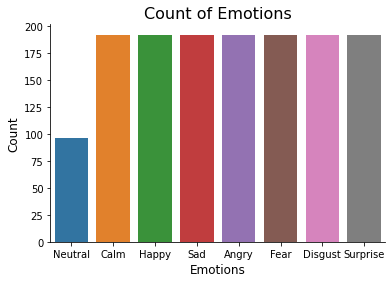

In [5]:
plt.title('Count of Emotions', size=16)
sns.countplot(Ravdess_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [6]:
from IPython.display import Audio

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()


In [7]:
Ravdess_df.head

<bound method NDFrame.head of       Emotions                                               Path
0      Neutral  D:/speech recognition/ravdess/Actor_01/03-01-0...
1      Neutral  D:/speech recognition/ravdess/Actor_01/03-01-0...
2      Neutral  D:/speech recognition/ravdess/Actor_01/03-01-0...
3      Neutral  D:/speech recognition/ravdess/Actor_01/03-01-0...
4         Calm  D:/speech recognition/ravdess/Actor_01/03-01-0...
...        ...                                                ...
1435  Surprise  D:/speech recognition/ravdess/Actor_24/03-01-0...
1436  Surprise  D:/speech recognition/ravdess/Actor_24/03-01-0...
1437  Surprise  D:/speech recognition/ravdess/Actor_24/03-01-0...
1438  Surprise  D:/speech recognition/ravdess/Actor_24/03-01-0...
1439  Surprise  D:/speech recognition/ravdess/Actor_24/03-01-0...

[1440 rows x 2 columns]>

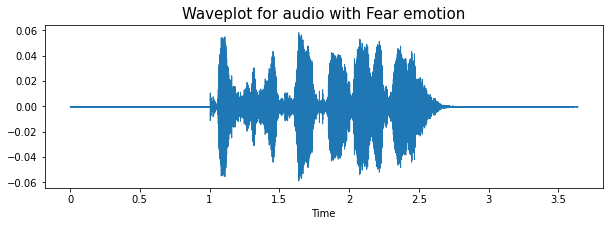

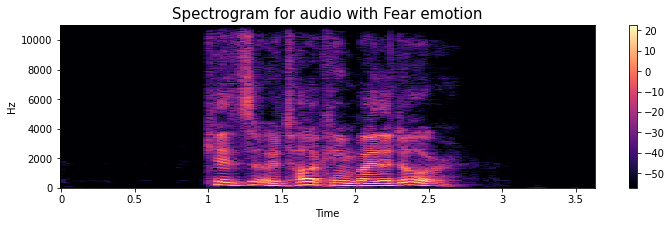

In [8]:

emotion='Fear'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

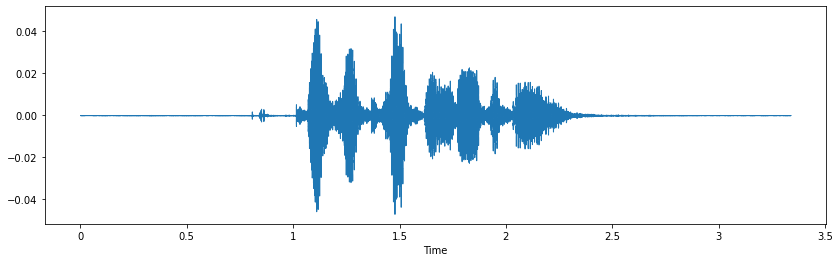

In [9]:
#Data augmentation

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(Ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

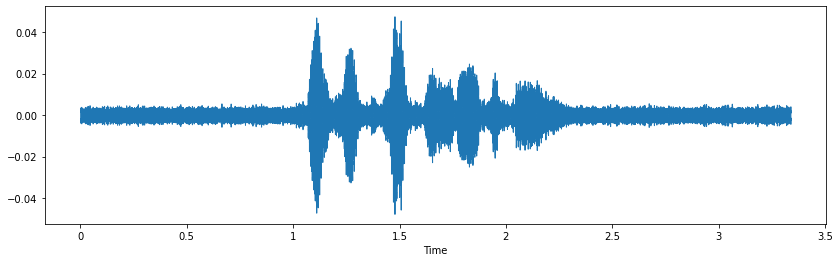

In [10]:
#noise injection
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate) 


In [11]:
#ZCR can be interpreted as a measure of the noisiness of a signal.
def extract_features(data):
    #zero srossing rate
    features  = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    features = np.hstack((features,zcr))
    
    #chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    features = np.hstack((chroma_stft,zcr))
    
    #mfcc
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    features = np.hstack((chroma_stft,zcr))
    
    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    features = np.hstack((rms,zcr))
    
    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    features = np.hstack((mel,zcr))
    
    return features

In [12]:
def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    #data with shift
    shift_data = shift(data)
    res4 = extract_features(shift_data)
    result = np.vstack((result,res4))
    
    return result

In [13]:
X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        
        Y.append(emotion)

len(X), len(Y), Ravdess_df.Path.shape 
# feature = get_features(Ravdess_df.Path[0])

C:\Users\SNEHA\AppData\Local\Temp\ipykernel_1300\393752923.py:9: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.time_stretch(data, rate)
C:\Users\SNEHA\AppData\Local\Temp\ipykernel_1300\393752923.py:16: FutureWarning: Pass sr=22050, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


(5760, 5760, (1440,))

In [14]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)

In [15]:
# As this is a multiclass classification problem onehotencoding our Y.
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray() 

In [16]:
import pickle
with open("encoder", "wb") as f: 
    pickle.dump(encoder, f)

In [17]:
from joblib import dump, load
dump(encoder, 'encoder.joblib') 

['encoder.joblib']

In [18]:
# splitting data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
#x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [19]:
x_train.shape

AttributeError: 'list' object has no attribute 'shape'

In [20]:
    
# scaling our data with sklearn's Standard scaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape 

((4320, 129), (4320, 8), (1440, 129), (1440, 8))

In [21]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape 

((4320, 129, 1), (4320, 8), (1440, 129, 1), (1440, 8))

In [22]:
# from keras.applications import resnet
# from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, AveragePooling2D, Input
# incept_model = resnet.ResNet50(include_top=False, weights ="imagenet", input_tensor=Input(shape=()))

In [23]:
# incept_model.summary()

In [24]:
# resnetModel = incept_model.output
# resnetModel = AveragePooling2D(pool_size=(7, 7))(resnetModel)
# resnetModel = Flatten(name="flatten")(resnetModel)
# resnetModel = Dense(256, activation="relu")(resnetModel)
# resnetModel = Dropout(0.5)(resnetModel)
# resnetModel = Dense(8, activation="softmax")(resnetModel)

In [25]:

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
#from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

# model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# model.add(Dropout(0.2))


model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()    
    
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4,verbose=0,patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=250, validation_data=(x_test, y_test), callbacks=[rlrp])
   

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 129, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 65, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 65, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 33, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 33, 256)           327936    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 17, 256)          0

68/68 [==============================] - 14s 205ms/step - loss: 0.9175 - accuracy: 0.6630 - val_loss: 1.0286 - val_accuracy: 0.6347 - lr: 4.0000e-04
Epoch 36/250
68/68 [==============================] - 14s 206ms/step - loss: 0.8925 - accuracy: 0.6720 - val_loss: 1.0288 - val_accuracy: 0.6292 - lr: 4.0000e-04
Epoch 37/250
68/68 [==============================] - 14s 200ms/step - loss: 0.8868 - accuracy: 0.6743 - val_loss: 1.0450 - val_accuracy: 0.6299 - lr: 4.0000e-04
Epoch 38/250
68/68 [==============================] - 14s 206ms/step - loss: 0.8858 - accuracy: 0.6708 - val_loss: 1.0208 - val_accuracy: 0.6229 - lr: 4.0000e-04
Epoch 39/250
68/68 [==============================] - 16s 236ms/step - loss: 0.8523 - accuracy: 0.6843 - val_loss: 0.9998 - val_accuracy: 0.6354 - lr: 4.0000e-04
Epoch 40/250
68/68 [==============================] - 15s 221ms/step - loss: 0.8290 - accuracy: 0.6986 - val_loss: 0.9927 - val_accuracy: 0.6451 - lr: 4.0000e-04
Epoch 41/250
68/68 [=====================

Epoch 86/250
68/68 [==============================] - 16s 232ms/step - loss: 0.6187 - accuracy: 0.7771 - val_loss: 0.8940 - val_accuracy: 0.7069 - lr: 1.0000e-07
Epoch 87/250
68/68 [==============================] - 15s 219ms/step - loss: 0.6228 - accuracy: 0.7812 - val_loss: 0.8940 - val_accuracy: 0.7063 - lr: 1.0000e-07
Epoch 88/250
68/68 [==============================] - 15s 221ms/step - loss: 0.6191 - accuracy: 0.7769 - val_loss: 0.8940 - val_accuracy: 0.7063 - lr: 1.0000e-07
Epoch 89/250
68/68 [==============================] - 15s 224ms/step - loss: 0.6159 - accuracy: 0.7782 - val_loss: 0.8939 - val_accuracy: 0.7063 - lr: 1.0000e-07
Epoch 90/250
68/68 [==============================] - 15s 220ms/step - loss: 0.6176 - accuracy: 0.7861 - val_loss: 0.8939 - val_accuracy: 0.7063 - lr: 1.0000e-07
Epoch 91/250
68/68 [==============================] - 15s 226ms/step - loss: 0.6273 - accuracy: 0.7810 - val_loss: 0.8940 - val_accuracy: 0.7063 - lr: 1.0000e-07
Epoch 92/250
68/68 [========

68/68 [==============================] - 15s 224ms/step - loss: 0.6231 - accuracy: 0.7792 - val_loss: 0.8941 - val_accuracy: 0.7069 - lr: 1.0000e-07
Epoch 137/250
68/68 [==============================] - 15s 223ms/step - loss: 0.6228 - accuracy: 0.7817 - val_loss: 0.8941 - val_accuracy: 0.7069 - lr: 1.0000e-07
Epoch 138/250
68/68 [==============================] - 15s 222ms/step - loss: 0.6286 - accuracy: 0.7741 - val_loss: 0.8942 - val_accuracy: 0.7069 - lr: 1.0000e-07
Epoch 139/250
68/68 [==============================] - 15s 217ms/step - loss: 0.6300 - accuracy: 0.7782 - val_loss: 0.8942 - val_accuracy: 0.7069 - lr: 1.0000e-07
Epoch 140/250
68/68 [==============================] - 15s 222ms/step - loss: 0.6245 - accuracy: 0.7743 - val_loss: 0.8941 - val_accuracy: 0.7069 - lr: 1.0000e-07
Epoch 141/250
68/68 [==============================] - 15s 225ms/step - loss: 0.6203 - accuracy: 0.7785 - val_loss: 0.8941 - val_accuracy: 0.7069 - lr: 1.0000e-07
Epoch 142/250
68/68 [===============

68/68 [==============================] - 10s 153ms/step - loss: 0.6271 - accuracy: 0.7806 - val_loss: 0.8942 - val_accuracy: 0.7076 - lr: 1.0000e-07
Epoch 187/250
68/68 [==============================] - 10s 153ms/step - loss: 0.6181 - accuracy: 0.7806 - val_loss: 0.8942 - val_accuracy: 0.7069 - lr: 1.0000e-07
Epoch 188/250
68/68 [==============================] - 10s 152ms/step - loss: 0.6229 - accuracy: 0.7764 - val_loss: 0.8942 - val_accuracy: 0.7069 - lr: 1.0000e-07
Epoch 189/250
68/68 [==============================] - 10s 149ms/step - loss: 0.6107 - accuracy: 0.7854 - val_loss: 0.8941 - val_accuracy: 0.7069 - lr: 1.0000e-07
Epoch 190/250
68/68 [==============================] - 10s 150ms/step - loss: 0.6193 - accuracy: 0.7806 - val_loss: 0.8941 - val_accuracy: 0.7069 - lr: 1.0000e-07
Epoch 191/250
68/68 [==============================] - 10s 150ms/step - loss: 0.6270 - accuracy: 0.7762 - val_loss: 0.8942 - val_accuracy: 0.7076 - lr: 1.0000e-07
Epoch 192/250
68/68 [===============

68/68 [==============================] - 10s 151ms/step - loss: 0.6089 - accuracy: 0.7859 - val_loss: 0.8942 - val_accuracy: 0.7076 - lr: 1.0000e-07
Epoch 237/250
68/68 [==============================] - 11s 156ms/step - loss: 0.6164 - accuracy: 0.7840 - val_loss: 0.8941 - val_accuracy: 0.7076 - lr: 1.0000e-07
Epoch 238/250
68/68 [==============================] - 11s 157ms/step - loss: 0.6131 - accuracy: 0.7745 - val_loss: 0.8941 - val_accuracy: 0.7076 - lr: 1.0000e-07
Epoch 239/250
68/68 [==============================] - 10s 155ms/step - loss: 0.6161 - accuracy: 0.7759 - val_loss: 0.8941 - val_accuracy: 0.7076 - lr: 1.0000e-07
Epoch 240/250
68/68 [==============================] - 10s 148ms/step - loss: 0.6202 - accuracy: 0.7833 - val_loss: 0.8941 - val_accuracy: 0.7076 - lr: 1.0000e-07
Epoch 241/250
68/68 [==============================] - 10s 149ms/step - loss: 0.6141 - accuracy: 0.7854 - val_loss: 0.8941 - val_accuracy: 0.7076 - lr: 1.0000e-07
Epoch 242/250
68/68 [===============

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 129, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 65, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 65, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 33, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 33, 256)           327936    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 17, 256)          0

In [27]:
model_name = 'Emotion_Voice_Detection_Model_4_0.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at D:\speech recognition\saved_models\Emotion_Voice_Detection_Model_4_0.h5 


In [28]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

45/45 [==============================] - 1s 20ms/step - loss: 0.8942 - accuracy: 0.7069
Accuracy of our model on test data :  70.6944465637207 %


ValueError: x and y must have same first dimension, but have shapes (300,) and (250,)

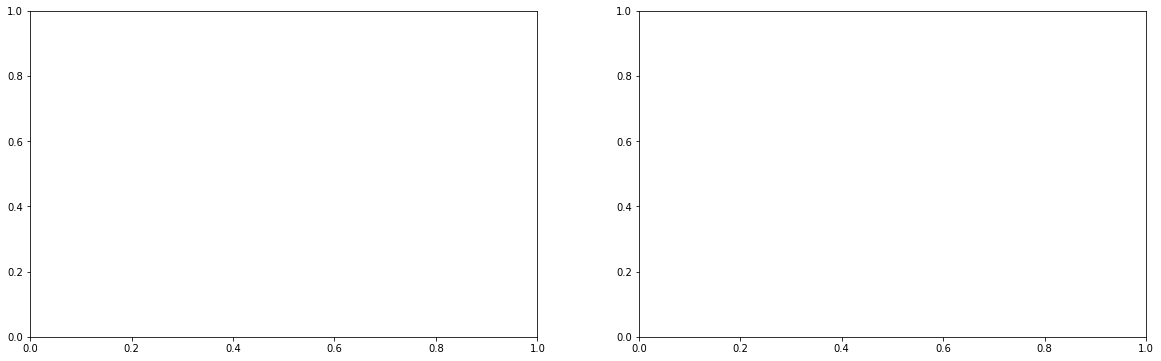

In [29]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(300)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [30]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)


In [31]:
pred_test.shape

(1440, 8)

In [32]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,Angry,Surprise
1,Calm,Sad
2,Disgust,Disgust
3,Angry,Angry
4,Happy,Happy
5,Happy,Angry
6,Sad,Happy
7,Angry,Angry
8,Happy,Happy
9,Calm,Calm


In [33]:
features = get_features("static/file.wav")
T=[]
for ele in features:
    T.append(ele)
    
Input = pd.DataFrame(T)    
scaler = StandardScaler()
Input = scaler.fit_transform(Input)
Input = np.expand_dims(Input, axis=2)
    
Output = model.predict(Input)
answer=Output.argmax(axis=1)
encoder1 = load('encoder.joblib')
final =encoder1.inverse_transform(Output)


C:\Users\SNEHA\AppData\Local\Temp\ipykernel_1300\393752923.py:9: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.time_stretch(data, rate)
C:\Users\SNEHA\AppData\Local\Temp\ipykernel_1300\393752923.py:16: FutureWarning: Pass sr=22050, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


In [34]:
print(answer)
print(final)

[0 0 1 0]
[['Angry']
 ['Angry']
 ['Calm']
 ['Angry']]


In [35]:
Output.shape


(4, 8)

In [36]:
print(final)

[['Angry']
 ['Angry']
 ['Calm']
 ['Angry']]
